# Detecção de Fake News - Preprocessamento

Base de dados usada no projeto: [ISOT Fake News Dataset](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data)

Essa base de dados contém fake news extraídas de diversas fontes e notícias verdadeiras do veículo Reuters.

BERT é bem mais robusto do que modelos clássicos de tokenização (como TF-IDF e Bag of Words). O embedding utilizado combina informações semânticas e posicionais, além disso, ele possui um mecanismo de atenção capaz de codificar o contexto de cada token na frase.

Dessa forma, a fase de limpeza do texto não precisa ser muito severa ao realizar o fine-tunning do BERT. Coisas que devem ser evitadas:

- **Não remover pontuação**: BERT foi treinado para entender pontuação como parte do significado.
- **Não remover stopwords**: Palavras como *is*, *the*, *a* são importantes para o contexto.
- **Não aplicar stemming ou lemmatização**: BERT entende as palavras em suas formas originais.
- **Evite limpezas agressivas**: O tokenizer do BERT já trata subpalavras, símbolos e padrões incomuns.


## Importa Bibliotecas

In [158]:
!pip install pandas matplotlib seaborn

In [159]:
import pandas as pd
import re # regular expression
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.special import softmax
import numpy as np

from nltk.corpus import stopwords
import nltk

from sklearn.model_selection import train_test_split

In [160]:
df_true = pd.read_csv('data/ISOT/True.csv')
df_fake = pd.read_csv('data/ISOT/Fake.csv')

## EDA e Limpeza

### Visão Geral: Notícias Reais

In [161]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [162]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [163]:
duplicated =  df_true.duplicated().sum()
print(f"Valores duplicados em df_true: {duplicated}")

Valores duplicados em df_true: 206


In [164]:
linhas_vazias = df_true[
    (df_fake['text'].isna()) | (df_fake['text'].str.strip() == '') |
    (df_fake['title'].isna()) | (df_fake['title'].str.strip() == '')
]

print(len(linhas_vazias))

614


/tmp/ipykernel_235562/2612014280.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  linhas_vazias = df_true[


In [165]:
df_true['subject'].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

### Visão Geral: Notícias Falsas

In [166]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [167]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [168]:
duplicated =  df_fake.duplicated().sum()
print(f"Valores duplicados em df_fake: {duplicated}")

Valores duplicados em df_fake: 3


In [169]:
# Filtrar linhas onde 'text' ou 'title' é NaN ou string vazia
linhas_vazias = df_fake[
    (df_fake['text'].isna()) | (df_fake['text'].str.strip() == '') |
    (df_fake['title'].isna()) | (df_fake['title'].str.strip() == '')
]

print(len(linhas_vazias))

630


In [170]:
df_fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

### Limpeza

In [171]:
df_true = df_true.drop(columns=['date', 'subject'])
df_fake = df_fake.drop(columns=['date', 'subject'])

Remoção de dados duplicados

In [172]:
def clean_df(df):
    # Remove duplicatas
    df = df.drop_duplicates()
    
    # Remove linhas com NaN em 'title' ou 'text'
    df = df.dropna(subset=['title', 'text'])
    
    # Remove linhas onde 'title' ou 'text' são strings vazias (ou só espaços)
    df = df.loc[
        (df['title'].str.strip() != '') & 
        (df['text'].str.strip() != '')
    ]
    
    return df

df_true = clean_df(df_true)
df_fake = clean_df(df_fake)

Várias notícias reais iniciam com "CIDADE - (Reuters)", informando o local de acontecimento do fato e a fonte. Assim, é importante remover essas informações, tendo em vista que elas podem ser consideradas uma vantagem injusta que poderia facilmente ser explorada pelo modelo ao classificar as notícias com verdadeiras. 

In [173]:
def remove_lead(text):
    """
    Remove o local e a fonte que precede as notícias reais
    """
    return re.sub(r'^([A-Z\s./]+\s)?\(Reuters\)\s-\s', '', text)

Abaixo testamos a função remove_lead.

In [174]:
df = pd.DataFrame({
    'text': [
        'WASHINGTON/NEW YORK (Reuters) - The president said today...',
        '(Reuters) - The market rose...',
        'WASHINGTON (Reuters) - Stocks fell...',
        'WEST PALM B. (Reuters) - A meteor destroided the city...'
    ]
})

df['cleaned'] = df['text'].apply(remove_lead)

print(df[['text', 'cleaned']])

                                                text  \
0  WASHINGTON/NEW YORK (Reuters) - The president ...   
1                     (Reuters) - The market rose...   
2              WASHINGTON (Reuters) - Stocks fell...   
3  WEST PALM B. (Reuters) - A meteor destroided t...   

                           cleaned  
0      The president said today...  
1               The market rose...  
2                   Stocks fell...  
3  A meteor destroided the city...  


In [175]:
def clean_text_columns(df):
    """
    Recebe um DataFrame e:
    - Remove URLs
    - Remove e-mails
    - Remove linhas que ficaram com 'title' ou 'text' vazios após a limpeza
    Retorna o DataFrame transformado.
    """
    df_copy = df.copy()
    text_cols = df_copy.select_dtypes(include=['object', 'string']).columns

    url_pattern = r'http\S+|www\.\S+'
    email_pattern = r'\S+@\S+'

    for col in text_cols:
        df_copy[col] = (
            df_copy[col]
            .str.replace(url_pattern, '', regex=True)
            .str.replace(email_pattern, '', regex=True)
            .str.strip()  # remove espaços em branco antes e depois
        )
    
    # Remove linhas onde 'title' ou 'text' ficaram vazios (string vazia)
    df_copy = df_copy.loc[
        (df_copy['title'] != '') & (df_copy['text'] != '')
    ]
    
    return df_copy

In [176]:
df_true['text'] = df_true['text'].apply(remove_lead)

df_true = clean_text_columns(df_true)
df_fake = clean_text_columns(df_fake)

In [177]:
print(df_true.shape)
print(df_fake.shape)

(21196, 2)
(17409, 2)


### Criação do Target e Junção de Datasets

In [178]:
df_fake['labels'] = 1
df_true['labels'] = 0

df_merged = pd.concat([df_fake, df_true], ignore_index=True)

In [179]:
df_merged.duplicated().sum()

2

In [180]:
df_merged = df_merged.drop_duplicates()

In [181]:
df_merged.head()

,title,text,labels
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...,1
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,1
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",1
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,1


In [182]:
df_merged['labels'].value_counts()

labels
0    21195
1    17408
Name: count, dtype: int64

In [183]:
# Split treino + teste
df_train, df_val_test = train_test_split(
    df_merged,
    test_size=0.4,
    random_state=42,
    stratify=df_merged['labels']
)

# Split treino + validação
df_test, df_val = train_test_split(
    df_val_test,
    test_size=0.5,
    random_state=42,
    stratify=df_val_test['labels']
)


In [184]:
cols = ["title", "text"] 

df_train["row_hash"] = df_train[cols].astype(str).sum(axis=1).apply(hash)
df_val["row_hash"] = df_val[cols].astype(str).sum(axis=1).apply(hash)
df_test["row_hash"] = df_test[cols].astype(str).sum(axis=1).apply(hash)

# Interseção de hashes
train_val_overlap = set(df_train["row_hash"]) & set(df_val["row_hash"])
train_test_overlap = set(df_train["row_hash"]) & set(df_test["row_hash"])
val_test_overlap = set(df_val["row_hash"]) & set(df_test["row_hash"])

print("Overlap hashes train-val:", len(train_val_overlap))
print("Overlap hashes train-test:", len(train_test_overlap))
print("Overlap hashes val-test:", len(val_test_overlap))

Overlap hashes train-val: 0
Overlap hashes train-test: 0
Overlap hashes val-test: 0


In [185]:
df_train = df_train.drop("row_hash",axis=1)
df_test = df_test.drop("row_hash",axis=1)
df_val = df_val.drop("row_hash",axis=1)

In [186]:
print(df_train.shape)
print(df_test.shape)
print(df_test.shape)

(23161, 3)
(7721, 3)
(7721, 3)


In [187]:
#Salvar cada split em CSV
df_train.to_csv("bert_train.csv", index=False)
df_val.to_csv("bert_val.csv", index=False)
df_test.to_csv("bert_test.csv", index=False)

### Exploração do Texto

In [188]:
def explore_distribution(df, colName):
    """
    Plot the distribution of colName
    """
    label_counts = df[colName].value_counts()
    label_percentages = round(label_counts / len(df) * 100, 2)

    print("colName distribution:")
    print(label_counts)
    print("\nPercentage:")
    print(label_percentages)

    label_counts.plot(kind='bar', title='{colName} Distribution')
    plt.xlabel(colName)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

colName distribution:
labels
0    21195
1    17408
Name: count, dtype: int64

Percentage:
labels
0    54.91
1    45.09
Name: count, dtype: float64


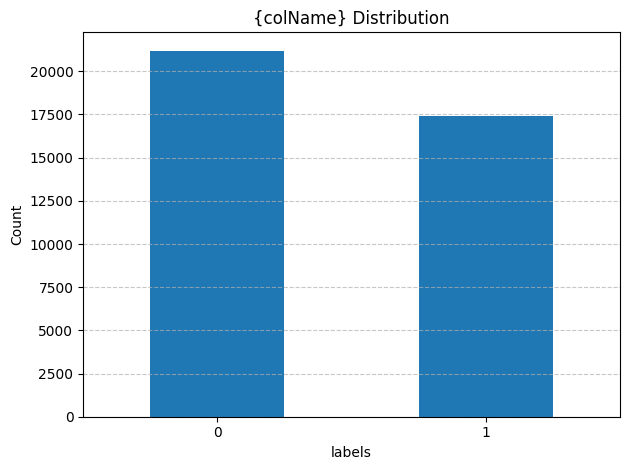

In [189]:
explore_distribution(df_merged, 'labels')

In [190]:
def plot_length_histograms(df_input):
    """
    Plot histograms of title and text lengths grouped by label.
    """
    df = df_input.copy()
    
    df['title_len'] = df['title'].astype(str).apply(len)
    df['text_len'] = df['text'].astype(str).apply(len)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    for label in df['labels'].unique():
        subset = df[df['labels'] == label]
        axes[0].hist(subset['title_len'], bins=50, alpha=0.5, label=label)
    axes[0].set_title("Comprimento do título por veracidade")
    axes[0].set_xlabel("Title Length")
    axes[0].set_ylabel("Count")
    axes[0].legend(title="Fake")
    axes[0].grid(True, linestyle='--', alpha=0.6)

    for label in df['labels'].unique():
        subset = df[df['labels'] == label]
        axes[1].hist(subset['text_len'], bins=50, alpha=0.5, label=label)
    axes[1].set_title("Comprimento do texto por veracidade")
    axes[1].set_xlabel("Text Length")
    axes[1].set_ylabel("Count")
    axes[1].legend(title="Fake")
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

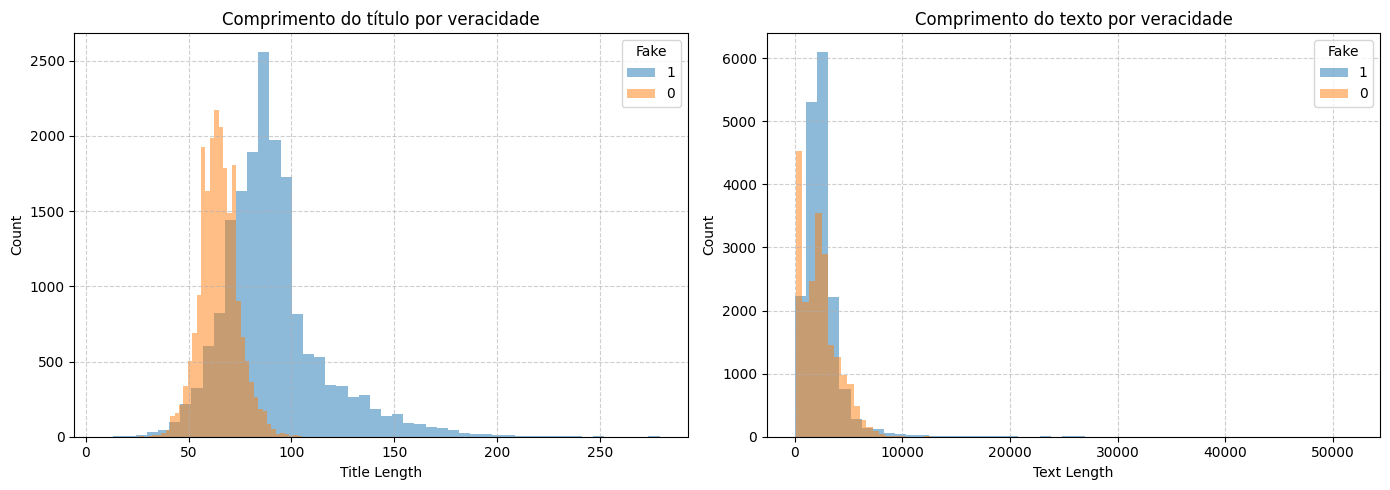

In [191]:
plot_length_histograms(df_merged)

In [192]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def plot_common_words(df, column='text', top_n=30):
    """
    Plot most common words in a text column by label ('fake' vs 'true'),
    excluding stopwords.
    """
    def clean_text(text):
        tokens = re.findall(r"\b\w+\b", str(text).lower())
        filtered = [word for word in tokens if word not in stop_words]
        return filtered

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for ax, label in zip(axes, [1, 0]):
        # Filtra o dataframe sem alterar o original
        texts = df[df['labels'] == label][column].dropna().apply(clean_text)
        word_counts = Counter(word for tokens in texts for word in tokens)
        common = word_counts.most_common(top_n)
        words, counts = zip(*common)

        title = 'Fake' if label == 1 else 'True'

        sns.barplot(x=list(counts), y=list(words), ax=ax)
        ax.set_title(f"Top {top_n} Words in {column.capitalize()} ({title})")
        ax.set_xlabel("Count")
        ax.set_ylabel("Word")

    plt.tight_layout()
    plt.show()

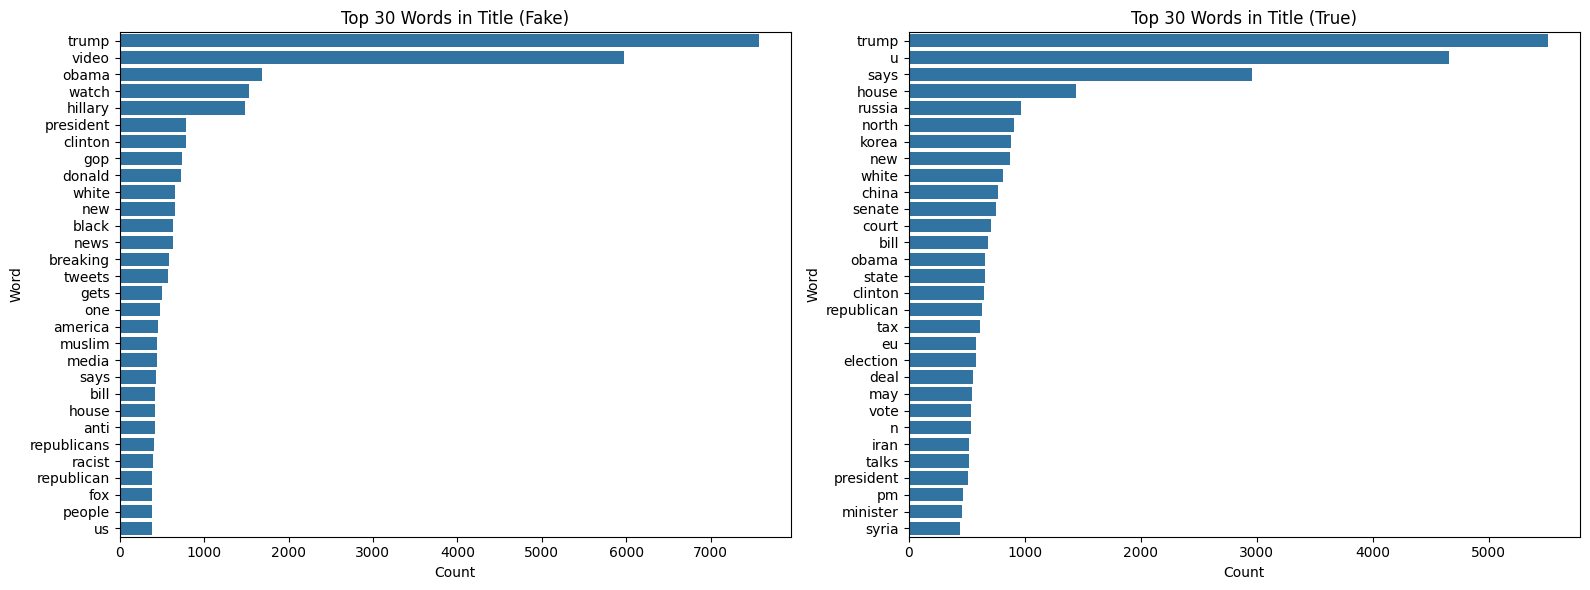

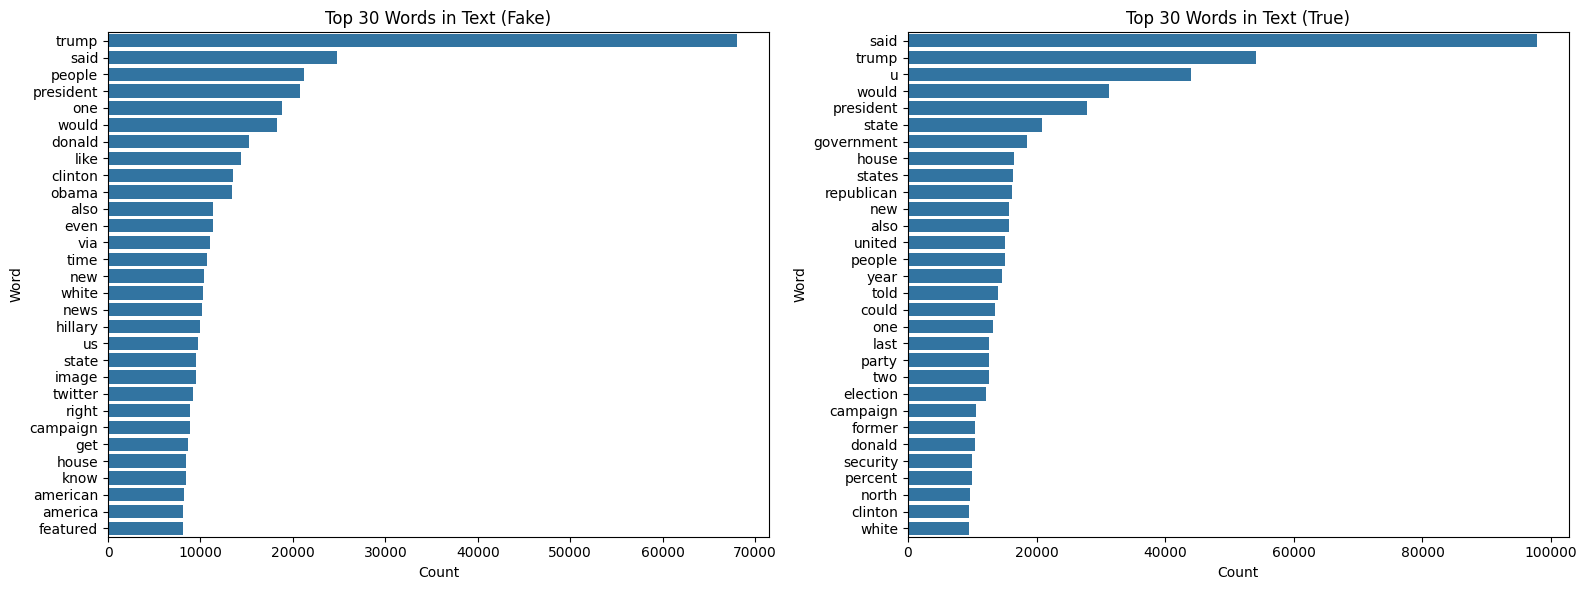

In [193]:
plot_common_words(df_merged, 'title')
plot_common_words(df_merged, 'text')